In [101]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
# %cd '/content/drive/My Drive/PHM_data_challenge'

In [103]:
# !unzip '/content/drive/My Drive/data_set.zip' -d '/content/drive/My Drive/PHM_data_challenge/'

In [104]:
%cd '/content/drive/My Drive/PHM_data_challenge/data_set'

/content/drive/My Drive/PHM_data_challenge/data_set


In [105]:
import os
import h5py
import time
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Conv2D, Flatten, Activation, Masking

In [106]:
### Set-up - Define file location
filename = 'N-CMAPSS_DS02-006.h5'

In [107]:
# Time tracking, Operation time (min):  0.003
t = time.process_time()  

# Load data
with h5py.File(filename, 'r') as hdf:
        # Development set
        # Features
        W_dev = np.array(hdf.get('W_dev'))             # W - scenario descriptors 
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s - measurements 
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v - virtual sensors 
        T_dev = np.array(hdf.get('T_dev'))             # T - health parameters

        # Target
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL - Remaining useful life
        
        # Auxiliary Information
        A_dev = np.array(hdf.get('A_dev'))             

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print('')
print("Operation time (min): " , (time.process_time()-t)/60)
print('')
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))


Operation time (min):  0.09774000083333476

W shape: (6517190, 4)
X_s shape: (6517190, 14)
X_v shape: (6517190, 14)
T shape: (6517190, 10)
A shape: (6517190, 4)


In [108]:
# deleting variables to free up RAM space
del W_dev, W_test, X_s_dev, X_s_test, X_v_dev, X_v_test, T_dev, T_test, A_dev, A_test

In [109]:
df_A = DataFrame(data=A, columns=A_var)
df_A_unique = df_A.drop_duplicates()
del df_A

df_W = DataFrame(data=W, columns=W_var)
df = pd.concat([df_A_unique, df_W], axis=1).reindex(df_A_unique.index)
del df_W
del df_A_unique

df_T = DataFrame(data=T, columns=T_var)
df_T_unique = df_T.drop_duplicates()
# df_T.nunique(axis=0) 
df_T_unique = df_T_unique.drop(columns=['fan_eff_mod', 'fan_flow_mod',	'LPC_eff_mod', 'LPC_flow_mod', 'HPC_eff_mod',	'HPC_flow_mod', 'HPT_flow_mod'])
df = pd.concat([df, df_T_unique], axis=1).reindex(df.index)
del df_T
del df_T_unique

df_X_s = DataFrame(data=X_s, columns=X_s_var)
df = pd.concat([df, df_X_s], axis=1).reindex(df.index)
del df_X_s

df_X_v = DataFrame(data=X_v, columns=X_v_var)
df = pd.concat([df, df_X_v], axis=1).reindex(df.index)
del df_X_v

In [110]:
RUL=[]
for i, j in enumerate(df['unit']):
  RUL.append(((df[df['unit'] == j]["cycle"]).values)[-1] - (df['cycle'].values)[int(i)])

df['RUL'] = RUL
df.head()

,unit,cycle,Fc,hs,alt,Mach,TRA,T2,HPT_eff_mod,LPT_eff_mod,LPT_flow_mod,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,T40,P30,P45,W21,W22,W25,W31,W32,W48,W50,SmFan,SmLPC,SmHPC,phi,RUL
0,2.0,1.0,3.0,1.0,10005.0,0.448497,76.903748,502.420918,-0.000638,0.0,0.0,600.148034,1438.498187,1818.027714,1228.129848,15.806267,11.577097,16.046971,20.126624,331.293679,336.631827,12.629361,2160.926416,8591.373490,3.855337,2797.727106,352.494060,62.768751,2420.557738,228.486927,228.487065,26.498785,15.899271,215.844851,228.411666,16.648833,9.898130,25.376144,41.893990,74.0
11764,2.0,2.0,3.0,1.0,10001.0,0.456246,80.331459,503.113330,-0.000488,0.0,0.0,604.080532,1452.574878,1843.561365,1240.242706,16.045428,11.633621,16.289775,20.560565,342.759352,348.186150,12.797577,2193.153017,8636.005763,4.040544,2834.335570,364.592828,65.013592,2465.223575,234.589392,234.592333,27.219969,16.331982,221.799503,234.700671,16.495472,10.002317,24.977666,42.437821,73.0
22265,2.0,3.0,3.0,1.0,10011.0,0.455049,79.100998,502.970188,-0.000626,0.0,0.0,602.835067,1447.752934,1834.591086,1235.817362,15.970362,11.620513,16.213565,20.421431,338.791496,344.191208,12.734671,2182.183883,8620.733027,3.975166,2821.355454,360.409641,64.238677,2451.372756,232.502168,232.501591,26.973000,16.183800,219.759391,232.546988,16.570681,9.942077,25.127668,42.240134,72.0
33358,2.0,4.0,3.0,1.0,10011.0,0.453852,78.573662,502.865464,-0.000580,0.0,0.0,602.221324,1445.590165,1830.510615,1233.839956,15.933517,11.612035,16.176159,20.354021,337.028090,342.415725,12.708837,2177.180751,8613.930146,3.946285,2815.570066,358.550498,63.892838,2444.524794,231.571897,231.571672,26.863154,16.117892,218.851521,231.588075,16.596242,9.931338,25.192684,42.152642,71.0
44081,2.0,5.0,3.0,1.0,10003.0,0.455742,78.925217,503.061387,-0.000823,0.0,0.0,602.792549,1447.221323,1833.938419,1235.614295,15.973153,11.629089,16.216399,20.420018,338.434444,343.829981,12.731968,2180.776000,8618.890228,3.969645,2820.219806,360.031394,64.169268,2451.486528,232.311449,232.311335,26.950526,16.170316,219.573716,232.350924,16.592424,9.910333,25.141235,42.225968,70.0


[Text(0, 0.5, 'unit'),
 Text(0, 1.5, 'cycle'),
 Text(0, 2.5, 'Fc'),
 Text(0, 3.5, 'hs'),
 Text(0, 4.5, 'alt'),
 Text(0, 5.5, 'Mach'),
 Text(0, 6.5, 'TRA'),
 Text(0, 7.5, 'T2'),
 Text(0, 8.5, 'HPT_eff_mod'),
 Text(0, 9.5, 'LPT_eff_mod'),
 Text(0, 10.5, 'LPT_flow_mod'),
 Text(0, 11.5, 'T24'),
 Text(0, 12.5, 'T30'),
 Text(0, 13.5, 'T48'),
 Text(0, 14.5, 'T50'),
 Text(0, 15.5, 'P15'),
 Text(0, 16.5, 'P2'),
 Text(0, 17.5, 'P21'),
 Text(0, 18.5, 'P24'),
 Text(0, 19.5, 'Ps30'),
 Text(0, 20.5, 'P40'),
 Text(0, 21.5, 'P50'),
 Text(0, 22.5, 'Nf'),
 Text(0, 23.5, 'Nc'),
 Text(0, 24.5, 'Wf'),
 Text(0, 25.5, 'T40'),
 Text(0, 26.5, 'P30'),
 Text(0, 27.5, 'P45'),
 Text(0, 28.5, 'W21'),
 Text(0, 29.5, 'W22'),
 Text(0, 30.5, 'W25'),
 Text(0, 31.5, 'W31'),
 Text(0, 32.5, 'W32'),
 Text(0, 33.5, 'W48'),
 Text(0, 34.5, 'W50'),
 Text(0, 35.5, 'SmFan'),
 Text(0, 36.5, 'SmLPC'),
 Text(0, 37.5, 'SmHPC'),
 Text(0, 38.5, 'phi'),
 Text(0, 39.5, 'RUL')]

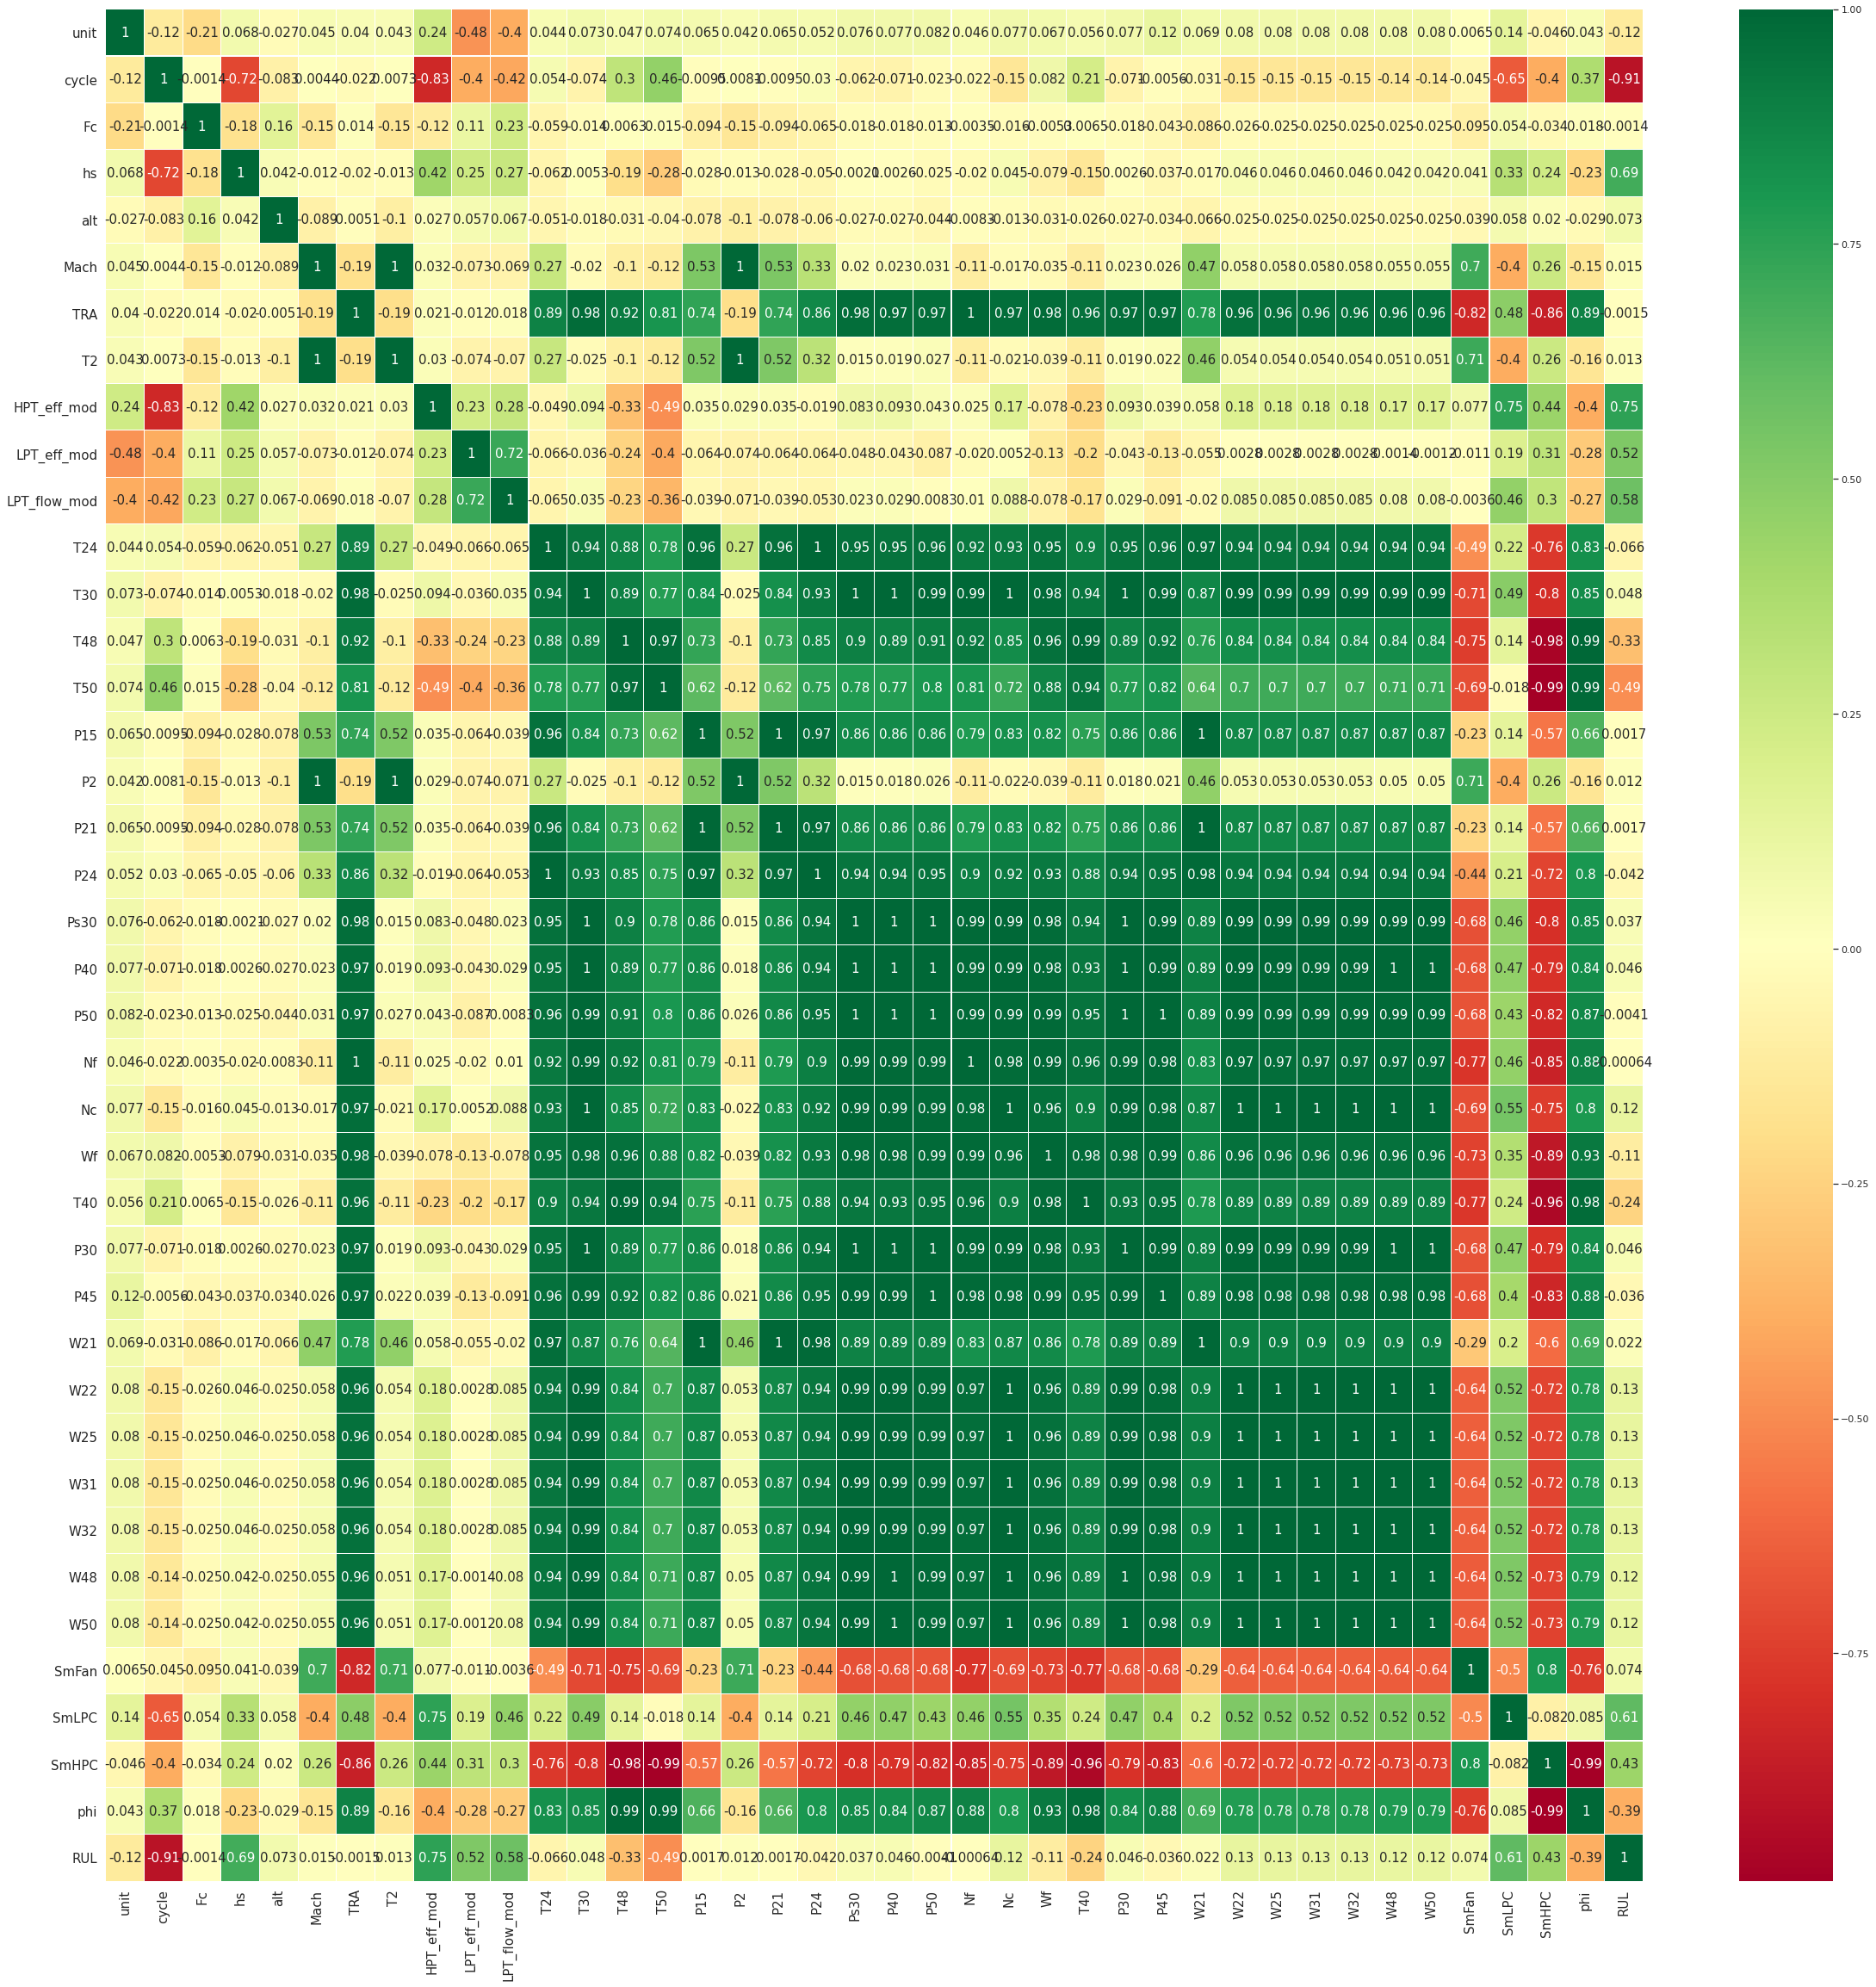

In [111]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(40, 40))
sns.set(font_scale=1)

# plot heat map
g=sns.heatmap(df[top_corr_features].corr(),cmap="RdYlGn", linewidths=0.1, annot=True, annot_kws={"size":15})
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15)
g.set_yticklabels(g.get_xmajorticklabels(), fontsize = 15)

In [112]:
delete_columns=[]

for col in df.columns:
    corr = df[col].corr(df['RUL'])
    #print(col,corr)
    if abs(corr)>0.1:
        pass
    else:    
        delete_columns.append(col)

In [113]:
df = df.drop(delete_columns, axis=1)
del delete_columns

In [114]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor()
model.fit(X, y)
print(model.feature_importances_)

[0.02894406 0.34547032 0.27130704 0.17465336 0.02977876 0.11406044
 0.0020262  0.00816196 0.00092296 0.00061974 0.00055547 0.00059866
 0.00085434 0.00075203 0.00066449 0.00084951 0.00069838 0.01313563
 0.00456671 0.00137992]


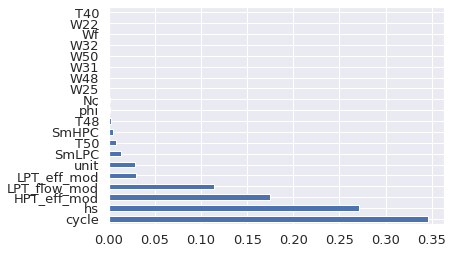

In [115]:
feat_importances = pd.Series(model.feature_importances_, index = X.columns)
feat_importances=feat_importances.sort_values(ascending=False)
feat_importances.nlargest(20).plot(kind='barh', fontsize =13)

In [116]:
drop = []
for i in range(feat_importances.size):
  if feat_importances[i] < 0.001:
    drop.append(feat_importances.index[i])

In [117]:
df = df.drop(drop, axis=1)
df = df.drop(['unit'], axis=1)
df.head()

,cycle,hs,HPT_eff_mod,LPT_eff_mod,LPT_flow_mod,T48,T50,SmLPC,SmHPC,phi,RUL
0,1.0,1.0,-0.000638,0.0,0.0,1818.027714,1228.129848,9.898130,25.376144,41.893990,74.0
11764,2.0,1.0,-0.000488,0.0,0.0,1843.561365,1240.242706,10.002317,24.977666,42.437821,73.0
22265,3.0,1.0,-0.000626,0.0,0.0,1834.591086,1235.817362,9.942077,25.127668,42.240134,72.0
33358,4.0,1.0,-0.000580,0.0,0.0,1830.510615,1233.839956,9.931338,25.192684,42.152642,71.0
44081,5.0,1.0,-0.000823,0.0,0.0,1833.938419,1235.614295,9.910333,25.141235,42.225968,70.0


## Time Series Pre-Processing

In [118]:
def create_dataset(df):
  # Scaling the DATA
  scaler = MinMaxScaler()
  df = scaler.fit_transform(df)

  # Getting into training shape with sliding window
  features = df[:, 0:-1]
  target = df[:, -1]

  ts_generator = TimeseriesGenerator(features, target, length=win_length, sampling_rate=1, batch_size=1)

  # Changing the shape of input to (no of smaples, window_length, features)
  X=[]
  y=[]
  for i in range(len(ts_generator)):
      x_temp, y_temp = ts_generator[i]
      X.append(x_temp.reshape(x_temp.shape[1], x_temp.shape[2]))
      y.append(y_temp)

  X=np.array(X)  
  y=np.array(y)  
  
  return X, y, scaler, features

In [119]:
win_length = 15   # Sliding Window Length
feature_num = len(df.columns) - 1   # Total number of features

X, y, scaler, features = create_dataset(df) 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

print(X.shape)
print(y.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(633, 15, 10)
(633, 1)
(506, 15, 10)
(506, 1)
(127, 15, 10)
(127, 1)


## Define models
1. CNN
2. LSTM
3. GRU
4. Bi-directional LSTM

In [120]:
# Create CNN Model
def create_CNN(win_length, feature_num):
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(win_length, feature_num, 1)))
    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    model.compile(loss="mse", optimizer="adam")

    return model

# Create LSTM Model
def create_LSTM(win_length, feature_num):
    model = Sequential()
    model.add(LSTM(
         units=100,
         return_sequences=True,
         input_shape=(win_length, feature_num)))
    model.add(Dropout(0.2))
    model.add(LSTM(
              units=100,
              return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='relu'))
    model.add(Activation("relu"))
    model.compile(loss="mse", optimizer="adam")

    return model

# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer 
    model.add(GRU (units = units, return_sequences = True, input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units))                 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    # Compile model
    model.compile(loss="mse", optimizer="adam")
   
    return model

# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(LSTM(units = units, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    # Compile model
    model.compile(loss="mse", optimizer="adam")
    return model

## Train Models

In [121]:
model_cnn = create_CNN(win_length, feature_num)
model_lstm = create_LSTM(win_length, feature_num)
model_gru = create_gru(64)
model_bilstm = create_bilstm(64)

def fit_model(model, X_train, y_train):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

    if model == model_cnn:
      X_train = np.expand_dims(X_train, axis=3)

    history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.2, batch_size = 16, shuffle = False, callbacks = [early_stop])
    return history

history_cnn = fit_model(model_cnn, X_train, y_train)
history_lstm = fit_model(model_lstm, X_train, y_train)
history_gru = fit_model(model_gru, X_train, y_train)
history_bilstm = fit_model(model_bilstm, X_train, y_train)

(506, 15, 10, 1)
Epoch 1/100
26/26 [==============================] - 8s 153ms/step - loss: 0.0650 - val_loss: 0.0604
Epoch 2/100
26/26 [==============================] - 3s 116ms/step - loss: 0.0383 - val_loss: 0.0465
Epoch 3/100
26/26 [==============================] - 3s 109ms/step - loss: 0.0339 - val_loss: 0.0422
Epoch 4/100
26/26 [==============================] - 3s 114ms/step - loss: 0.0311 - val_loss: 0.0366
Epoch 5/100
26/26 [==============================] - 3s 119ms/step - loss: 0.0275 - val_loss: 0.0330
Epoch 6/100
26/26 [==============================] - 3s 106ms/step - loss: 0.0238 - val_loss: 0.0295
Epoch 7/100
26/26 [==============================] - 3s 119ms/step - loss: 0.0220 - val_loss: 0.0274
Epoch 8/100
26/26 [==============================] - 3s 99ms/step - loss: 0.0199 - val_loss: 0.0241
Epoch 9/100
26/26 [==============================] - 3s 112ms/step - loss: 0.0180 - val_loss: 0.0211
Epoch 10/100
26/26 [==============================] - 3s 101ms/step - loss:

## Predictions, Plotting and Inference



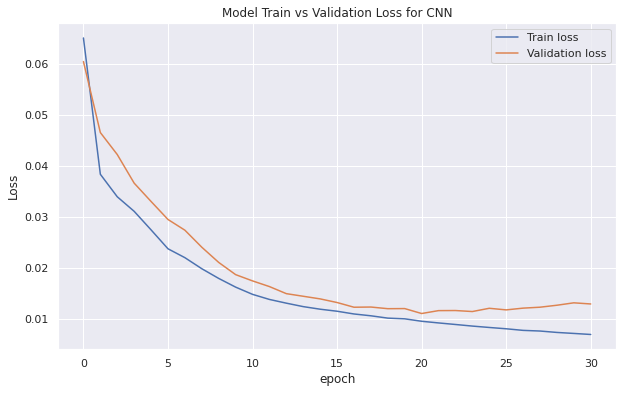

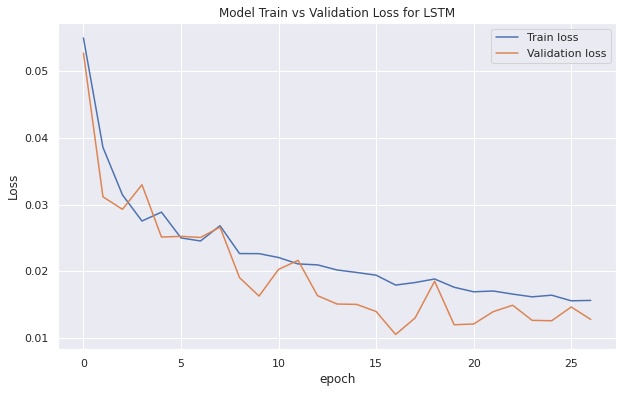

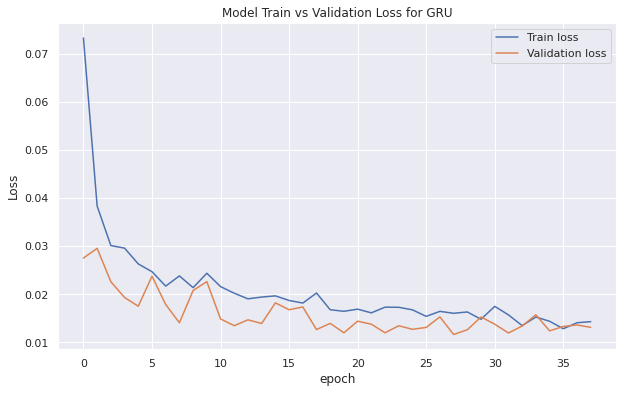

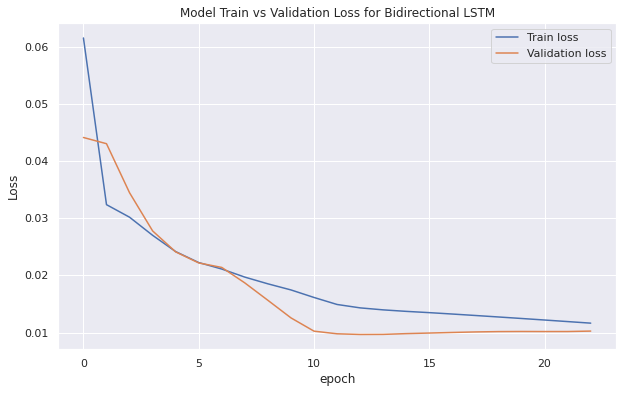

In [122]:
# Plot train loss and validation loss
def plot_loss (history, model_name):

    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

plot_loss(history_cnn, 'CNN')
plot_loss(history_lstm, 'LSTM')
plot_loss(history_gru, 'GRU')
plot_loss(history_bilstm, 'Bidirectional LSTM')

In [123]:
# create empty table with 12 fields
empty1 = np.zeros(shape=(len(y_test), feature_num+1) )
# put the predicted values in the right field
empty1[:,-1] = y_test[:, -1]
# inverse transform and then select the right field
y_test = scaler.inverse_transform(empty1)[:,-1]

# create empty table with 12 fields
empty2 = np.zeros(shape=(len(y_train), feature_num+1) )
# put the predicted values in the right field
empty2[:,-1] = y_train[:, -1]
# inverse transform and then select the right field
y_train = scaler.inverse_transform(empty2)[:,-1]

In [126]:
# Make prediction
def prediction(model, X_test):
    if model == model_cnn:
      X_test = np.expand_dims(X_test, axis=3)

    prediction = model.predict(X_test)
    empty = np.zeros(shape=(len(prediction), feature_num+1) )
    empty[:,-1] = prediction[:, -1]
    prediction = scaler.inverse_transform(empty)[:,-1]

    return prediction

prediction_cnn = prediction(model_cnn, X_test)
prediction_lstm = prediction(model_lstm, X_test)
prediction_gru = prediction(model_gru, X_test)
prediction_bilstm = prediction(model_bilstm, X_test)

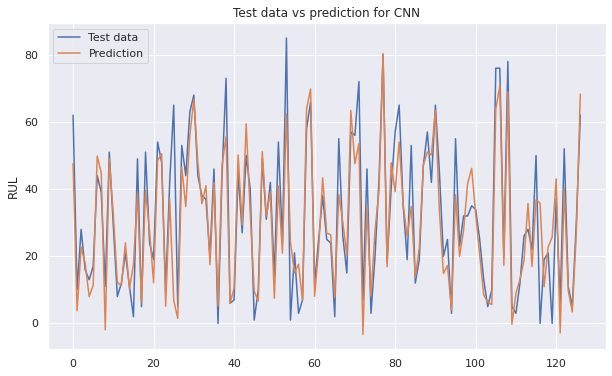

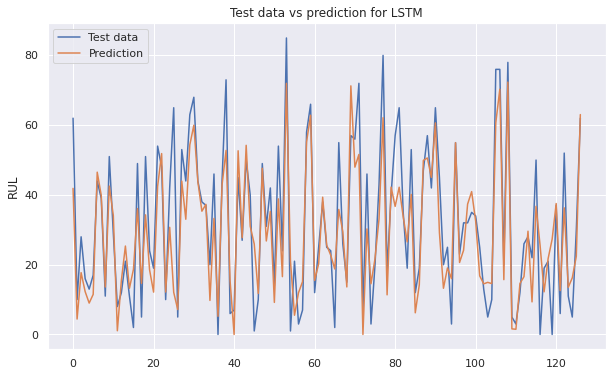

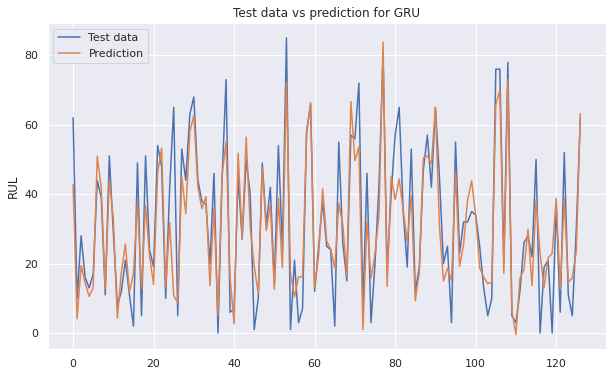

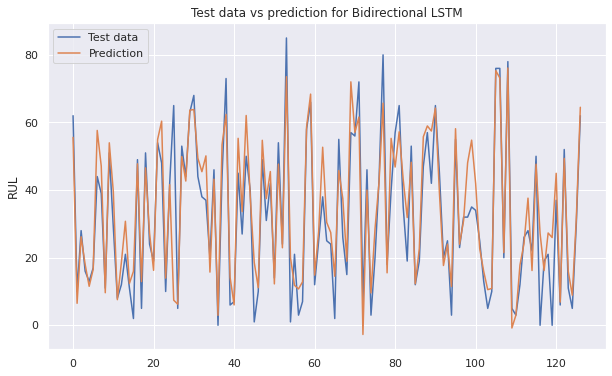

In [128]:
# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    # plt.xlabel('cycle')
    plt.ylabel('RUL')

plot_future(prediction_cnn, 'CNN', y_test)
plot_future(prediction_lstm, 'LSTM', y_test)       
plot_future(prediction_gru, 'GRU', y_test)
plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)

In [129]:
# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')

evaluate_prediction(prediction_cnn, y_test, 'CNN')
evaluate_prediction(prediction_lstm, y_test, 'LSTM')
evaluate_prediction(prediction_gru, y_test, 'GRU')
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectiona LSTM')

CNN:
Mean Absolute Error: 7.0115
Root Mean Square Error: 10.1229

LSTM:
Mean Absolute Error: 8.1314
Root Mean Square Error: 10.9353

GRU:
Mean Absolute Error: 7.2398
Root Mean Square Error: 9.9086

Bidirectiona LSTM:
Mean Absolute Error: 6.4530
Root Mean Square Error: 9.5111

